**first of all we use the bellow code to find out our GPU model, if the GPU model is not p100 we try to refresh the run time so that we can get our desired model.**

In [2]:
!nvidia-smi


Sun Aug  2 08:55:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

**in this cell we obtain the cifar10 dataset images and labels.**

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


**now a single image is shown to make sure we have loaded the data set properly.we also print the type of our images and the max value of the arrays.**

<class 'numpy.uint8'>
255


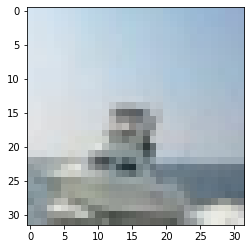

In [6]:
plt.imshow(train_images[100])
print(type(train_images[0][0][0][0]))

print(np.max(train_images))

**the dataset type is changed to float32 in order to have more precision when normalizing.**
**in the last line of this cell we normilize the arrays by subtracing by half of the maximum value and then deviding by the same value**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[213. 229. 242.]
  [211. 227. 240.]
  [211. 227. 240.]
  ...
  [151. 174. 206.]
  [151. 174. 206.]
  [149. 172. 204.]]

 [[214. 229. 241.]
  [212. 227. 239.]
  [212. 227. 239.]
  ...
  [152. 175. 207.]
  [152. 175. 207.]
  [151. 174. 205.]]

 [[216. 229. 239.]
  [214. 227. 237.]
  [213. 227. 237.]
  ...
  [153. 176. 206.]
  [153. 176. 206.]
  [151. 174. 204.]]

 ...

 [[145. 159. 165.]
  [136. 148. 154.]
  [143. 152. 158.]
  ...
  [216. 217. 206.]
  [196. 197. 191.]
  [183. 183. 182.]]

 [[139. 153. 159.]
  [129. 142. 148.]
  [129. 139. 145.]
  ...
  [227. 228. 219.]
  [223. 224. 219.]
  [209. 209. 209.]]

 [[137. 152. 157.]
  [143. 155. 161.]
  [136. 145. 152.]
  ...
  [209. 209. 203.]
  [217. 217. 213.]
  [228. 228. 226.]]]


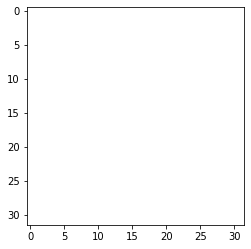

In [7]:
train_images = train_images.astype('float32')
plt.imshow(train_images[100])
print(train_images[100])
train_images = (train_images - 127.5) / 127.5


**here we determine the batch size which is 100, and shuffle the data set with buffer size of 6000, note that the buffer size is not really important, trian_dataset is the initial data set that has been shuffled and batched**

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(type(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


**we try to rebuild the initial image using the normilized array to see if it works.**

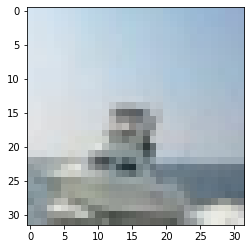

In [9]:
import copy
a=copy.deepcopy(train_images[100])
a=a*127.5+127.5
a=a.astype('int')
plt.imshow(a)

**we start to build the model.**
**first we construct the Generator. we use the sequential mode to make our NNs.**
**our generator has 4 deconvolution layers.**
**each deconv has a stride size of (2,2). the padding here is different from the convolution padding, meaning that it would assume the padding for the input of the layer.**

**with using the above stride size and using the 'same' padding we will achieve a layer that increases the input size of each feature map with the coefficient of 2. the number of our filters thus the number of feature maps are as follows: 512, 256, 128, 64 ,3.**

**after each deconv layer a batch mormalization layer is used. exept the last deconv layer.**

**the Activision Function for all layers is RELU function exept the last layer that has Tanh as its activision function. the reason being that we need the output layer to be in range of 0 and 1 to be equivalent to the real images. sigmoid function can also be used.**

**the first layer is a Dense layer that produces 2*2*512 outputs from an input with the size of 100, the input of this model is sized 100 noise.**
**then we reshape this vector to an (2,2,512) array.**

**the output shape is (32,32,3) same as our real images.**




In [10]:
from tensorflow.keras import layers
from tensorflow.keras import activations

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(2*2*512, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((2, 2, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.relu))
    assert model.output_shape == (None, 2, 2, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.relu))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.relu))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(activations.relu))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False,activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

**in this cell we generate the generator model.**
**then a 100 length normal noise is made and fed to the generator to make a noisy image because the generator is not trained yet**

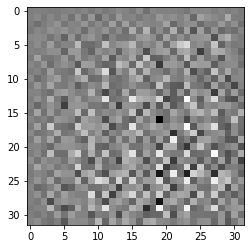

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

**we continue our work by making the discriminator model. again we use the sequential mode**

**this model has 4 convolution layers with the same stride size and padding as the generator. therefore each layer reduces the feature maps size by the coefficient of 0.5**

**the number of filters learned in each layer are as follows: 64, 128, 256, 512**

**after each conv layer a batch normalization layer is used**

**the TF used in every layer is Leaky Relu exept the last layer that uses sigmoid function in order to generate an output in range of 0 and 1 equivalent to the target values which are 0 and 1.**

**a Dense layer is used in the last part to produce a singular output using the outputs of the last conv layer**


In [12]:
def make_discriminator_model():
  
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 2, 2, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    model.add(layers.Activation(activations.sigmoid))

  
    return model

In [13]:
discriminator = make_discriminator_model()

**here we make two functions in order to calculate the loss function. all LFs are cross_enropy, real data loss is calculated with 0.9 target in order to have smoother learning process. the generator loss is devided by 4 which doesn't make much difference in the learning process. it only acts as a bias and makes the learning rate impact even smaller**

**the optimizers are both ADAMS with LR= 0.0001 for generator and LR=0.001 for the discriminator because discriminator has 2 times more data to learn with**

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
real_loss_list=[]
fake_loss_list=[]
gen_loss_list=[]
def discriminator_loss(real_output, fake_output):
    dimension=real_output.shape
    real_loss = cross_entropy(tf.fill(value=0.9,dims=dimension), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    real_loss_list.append(real_loss)
    fake_loss_list.append(fake_loss)

    return total_loss
def generator_loss(fake_output):
    gen_loss=cross_entropy(tf.ones_like(fake_output), fake_output)
    gen_loss=gen_loss/4
    gen_loss_list.append(gen_loss)

    return gen_loss

generator_optimizer = tf.keras.optimizers.Adam(lr=1e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1e-3,beta_1=0.5)


In [15]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**here we generate the destination path and checkpoint in order to save both models.**

In [16]:
checkpoint_dir = '/content/gdrive/My Drive/kharesave/ss4'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**the noise dimension is 100, the number of epochs in the first run which we have given the outputs in the result is 540, seed is a set of random values which we use to generate the result images after each epoch**

In [17]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 100
seed = tf.random.uniform(shape=[num_examples_to_generate, noise_dim],minval=-1,maxval=1,dtype=tf.dtypes.float32)

**the train_step function recieves a batch of images, thus is called 500 times in each epoch.**

**in this function we generate batch size number of noises with dimention of 100**

**we use the tf.gradienttape() Class to learn the models, by using the "with" statment the --start-- method of above func is called and then the --exit-- method. this results in taping the prosidures of how the model works. so in the "with" statment we generate fake images with the generator. we feed the fake images and real images to the discriminator. we calculate the LFs. now that the gradient tape knows how our model works we calculate the gradients of each loss function by the derivatives of each model's trainable variables. then we apply these gradients to the optimizers to train the trainable vars.**

In [18]:


def train_step(images):
    noise = tf.random.uniform(shape=[BATCH_SIZE, noise_dim],minval=-1,maxval=1,dtype=tf.dtypes.float32)
    # print('s')

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

**the train function calls the train_step func for every batch in every epoch. then it saves the generated images and the model to my google drive.**

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images 
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**this function generates the fake images via the generator and by using the seed noises that i mentioned, the training is set to false so the we dont train the generator in this function. then the fake images are shown and saved**

In [20]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 10, i+1)
      x=predictions[i]
      y=x.numpy()
      y=y*127.5+127.5
      y=y.astype(int)
      plt.imshow(y)
      plt.axis('off')

  im_dir = '/content/gdrive/My Drive/kharesave/images4'
  im_prefix = os.path.join(im_dir, 'image_at_epoch_{:04d}.png'.format(epoch))  
  if (epoch+1) % 10==0:
    plt.savefig(im_prefix)
  plt.show()

**at last we call the train function**

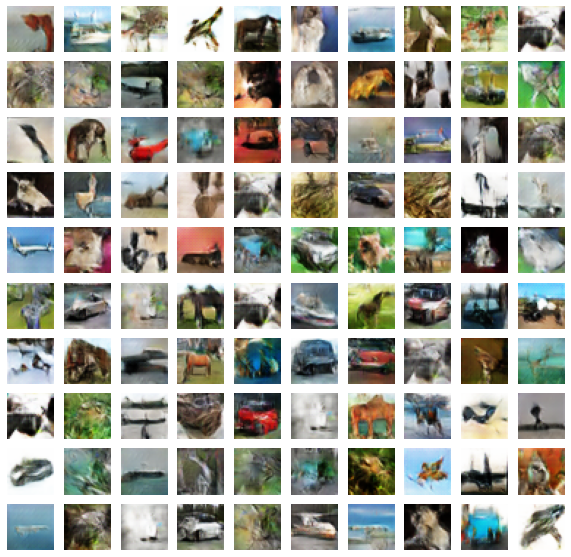

In [21]:
train(train_dataset, EPOCHS)

**a list of all loss function values is made in the training, here we try to save these lists, and arrays of each loss function's average.** 

In [ ]:
import numpy as np

gen_array=np.array(gen_loss_list)
real_array=np.array(real_loss_list)
fake_array=np.array(fake_loss_list)

# np.savetxt('/content/gdrive/My Drive/kharesave/realloss.txt',real_array)
# np.savetxt('/content/gdrive/My Drive/kharesave/fakeloss.txt',fake_array)
# np.savetxt('/content/gdrive/My Drive/kharesave/genloss.txt',gen_array)

g_list=[]
r_list=[]
f_list=[]

for i in range(EPOCHS):
  real_sum=0
  fake_sum=0
  gen_sum=0

  for j in range(500):
    real_sum=real_sum+real_array[i*500+j]
    fake_sum=fake_sum+fake_array[i*500+j]
    gen_sum=gen_sum+gen_array[i*500+j]

  real_sum=real_sum/500
  fake_sum=fake_sum/500
  gen_sum=gen_sum/500
  r_list.append(real_sum)
  f_list.append(fake_sum)
  g_list.append(gen_sum)

r_array=np.array(r_list)
f_array=np.array(f_list)
g_array=np.array(g_list)



# np.savetxt('/content/gdrive/My Drive/kharesave/rloss.txt',r_array)
# np.savetxt('/content/gdrive/My Drive/kharesave/floss.txt',f_array)
# np.savetxt('/content/gdrive/My Drive/kharesave/gloss.txt',g_array)







**now we load the loss function values and plot the last batch's LF in every epoch. we have done this for 200 epochs**

<function matplotlib.pyplot.show>

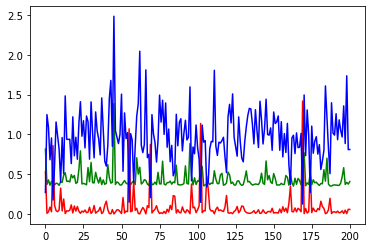

In [30]:
import numpy as np

r=np.loadtxt('/content/gdrive/My Drive/kharesave/realloss.txt')
f=np.loadtxt('/content/gdrive/My Drive/kharesave/fakeloss.txt')
g=np.loadtxt('/content/gdrive/My Drive/kharesave/genloss.txt')

g_list=[]
r_list=[]
f_list=[]


for i in range(EPOCHS):

  for j in range(500):
    if (i*500+j)%499==0:
      g_list.append(g[i*500+j])
      r_list.append(r[i*500+j])
      f_list.append(f[i*500+j])


r_array=np.array(r_list)
f_array=np.array(f_list)
g_array=np.array(g_list)





x=np.array(range(EPOCHS+1))
plt.figure(1)
plt.plot(x,r_array,'g')
plt.plot(x,f_array,'r')
plt.plot(x,g_array,'b')
plt.show
